### 오토 인코더 기반 이상탐지 튜토리얼
##### 데이터 불러오기

In [73]:
import torch
import torchvision.datasets as datasets
from utils import set_seed

import warnings
warnings.filterwarnings(action='ignore')

set_seed(2022) # fix random number generator seed
device = 'cuda:0' # use gpu. if you want to use cpu, assign like that -> device = 'cpu'

def load_MNIST():
    trainset = datasets.MNIST(root='./data', train=True, download=False)
    testset = datasets.MNIST(root='./data', train=False, download=False)

    X = torch.cat([trainset.data, testset.data], dim=0)
    
    return X

def load_KMNIST():
    trainset = datasets.KMNIST(root='./data', train=True, download=False)
    testset = datasets.KMNIST(root='./data', train=False, download=False)

    X = torch.cat([trainset.data, testset.data], dim=0)

    return X

M_X = load_MNIST()
K_X = load_KMNIST()

print(f'MNIST data shape : {M_X.shape} | K-MNIST data shape : {K_X.shape}')

MNIST data shape : torch.Size([70000, 28, 28]) | K-MNIST data shape : torch.Size([70000, 28, 28])


#### 이상탐지를 위한 데이터 세팅

In [2]:
import random
import numpy as np

# randomly sampling img indices
m_idx = np.random.choice(60000, size=(30000,), replace=False) # total normal data   : 30000
k_idx = np.random.choice(60000, size=(10000,), replace=False) # total abnormal data : 10000

# shuffling indices to split data to train/valid/test
random.shuffle(m_idx)
random.shuffle(k_idx)

# sampling normal & abnormal data
normal_X = M_X[m_idx]
abnormal_X = K_X[k_idx]

# generate targets, if normal -> 0 elif abnormal -> 1
normal_y = torch.LongTensor([0]*30000)
abnormal_y = torch.LongTensor([1]*10000)

# shuffling indices to split data to train/valid/test
random.shuffle(m_idx)
random.shuffle(k_idx)

# split data to train/valid/test sets
# train set -> # of normal : 20000
X_train, y_train = normal_X[:20000], normal_y[:20000]

# valid set -> # of normal : 5000 | # of abnormal : 5000
X_valid = torch.cat([normal_X[20000:25000],abnormal_X[:5000]])
y_valid = torch.cat([normal_y[20000:25000],abnormal_y[:5000]])

# valid set -> # of normal : 5000 | # of abnormal : 5000
X_test = torch.cat([normal_X[25000:],abnormal_X[5000:]])
y_test = torch.cat([normal_y[25000:],abnormal_y[5000:]])

print(f'train / valid / test = {len(X_train)} / {len(X_valid)} / {len(X_test)}')

train / valid / test = 20000 / 10000 / 10000


In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class Custom_dataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        
        #transform img size (28,28) to (32,32)
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(32),
                                             transforms.ToTensor()])
        self.X, self.y = X, y
            
    def __getitem__(self, idx):
        return {'X':self.transform(self.X[idx]), 'y':self.y[idx]}
    
    def __len__(self):
        return len(self.y)
    
train_set = Custom_dataset(X_train, y_train)
valid_set = Custom_dataset(X_valid, y_valid)
test_set = Custom_dataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

#### 오토인코더 모델

In [4]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, feature_maps=[16,32,64,128]):
        super().__init__()
        
        self.enc = self.make_layers(feature_maps)
        self.gap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        """x : batch, 1, W, H"""

        x = self.enc(x) # B, 128, 2, 2
        x = self.gap(x) # B, 128, 1, 1
        
        return x
    
    def make_layers(self, feature_maps):
        layers = []
        input_dim = 1
        for i, feature_dim in enumerate(feature_maps):

            layers += [nn.Conv2d(input_dim, feature_dim, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(feature_dim),
                    nn.ReLU(True),
                    nn.MaxPool2d((2,2),2)]

            input_dim = feature_dim
        return nn.Sequential(*layers)

In [5]:
class Decoder(nn.Module):
    def __init__(self, feature_maps=[128,64,32,16,1]):
        super().__init__()
                
        self.dec = self.make_layers(feature_maps)
    
    def forward(self, x):
        """x : batch, hid dim, 1, 1"""
        x = self.dec(x) # B, 1, 32, 32
        return x
    
    def make_layers(self, feature_maps):
        layers = []
        input_dim = 128
        for i, feature_dim in enumerate(feature_maps):
            if i+1 != len(feature_maps):
                layers += [nn.ConvTranspose2d(input_dim, feature_dim, kernel_size=2, stride=2),
                        nn.BatchNorm2d(feature_dim),
                        nn.ReLU(True)]
            else:
                layers += [nn.ConvTranspose2d(input_dim, feature_dim, kernel_size=2, stride=2)]
            input_dim = feature_dim
        return nn.Sequential(*layers)

In [6]:
from utils import initialize_weights

class Autoencoder(nn.Module):
    def __init__(self,
                 enc_feature_maps=[16,32,64,128],
                 dec_feature_maps=[128,64,32,16,1]):
        super().__init__()
                
        self.enc = Encoder(feature_maps=enc_feature_maps)
        self.dec = Decoder(feature_maps=dec_feature_maps)
        
        self.apply(initialize_weights)
    
    def forward(self, x):
        """x: B,3,32,32"""
        x = self.enc(x) # B, hid dim, 1, 1
        x = self.dec(x) # B, 3, 32, 32
        return x
    
model = Autoencoder().to(device)

#### 오토인코더 기반 이상탐지 프레임워크

##### 학습 단계

In [7]:
import time

def train(train_loader, model, loss_fn, opt, epochs = 50):
    
    total_loss = []
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        since = time.time()
        
        for i, batch in enumerate(train_loader):
            x = batch['X'].to(device) # B, 1, 32, 32
            pred = model(x) # B, 1, 32, 32
            
            loss = loss_fn(pred, x)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss/(i+1)
        total_loss.append(train_loss)
        t_time = time.time() - since
        
        print(f'Epoch : {epoch} | train loss : {round(train_loss, 6)} | required time : {round(t_time,2)}')

    return total_loss
    
epochs = 50
loss_fn = nn.MSELoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

total_loss = train(train_loader, model, loss_fn, opt, epochs=epochs)

Epoch : 1 | train loss : 0.783915 | required time : 5.11
Epoch : 2 | train loss : 0.084003 | required time : 1.66
Epoch : 3 | train loss : 0.039879 | required time : 1.8
Epoch : 4 | train loss : 0.026536 | required time : 1.73
Epoch : 5 | train loss : 0.020347 | required time : 1.77
Epoch : 6 | train loss : 0.01693 | required time : 1.65
Epoch : 7 | train loss : 0.014824 | required time : 1.68
Epoch : 8 | train loss : 0.013585 | required time : 1.7
Epoch : 9 | train loss : 0.012675 | required time : 1.65
Epoch : 10 | train loss : 0.011724 | required time : 1.78
Epoch : 11 | train loss : 0.011165 | required time : 1.74
Epoch : 12 | train loss : 0.010584 | required time : 1.76
Epoch : 13 | train loss : 0.010097 | required time : 1.65
Epoch : 14 | train loss : 0.009702 | required time : 1.79
Epoch : 15 | train loss : 0.009278 | required time : 1.94
Epoch : 16 | train loss : 0.008808 | required time : 1.78
Epoch : 17 | train loss : 0.008522 | required time : 3.3
Epoch : 18 | train loss : 0

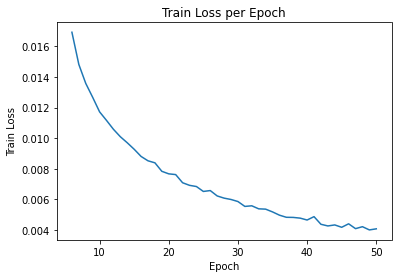

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(6,epochs+1), y=total_loss[5:])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.show()

Text(0.5, 1.0, 'Reconstruction Image 2')

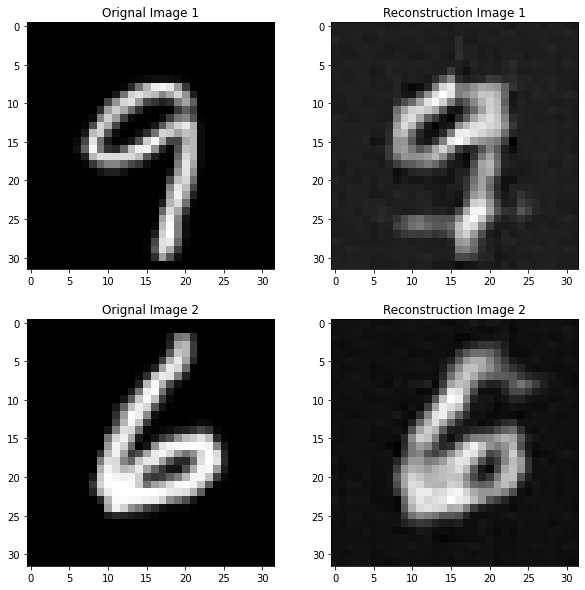

In [9]:
# get original imgs
batch = next(iter(train_loader))
original = batch['X'][:2].to(device) # 2, 3, 32, 32

# get reconstruction imgs
with torch.no_grad():
    pred = model(original) # 2, 3, 32, 32

# transform tensor to numpy with shape 2, 32, 32, 3
original = np.transpose(original.detach().cpu().numpy(), (0, 2, 3, 1))
pred = np.transpose(pred.detach().cpu().numpy(), (0, 2, 3, 1))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(original[0], cmap='gray')
plt.title('Orignal Image 1')

plt.subplot(2,2,2)
plt.imshow(pred[0], cmap='gray')
plt.title('Reconstruction Image 1')

plt.subplot(2,2,3)
plt.imshow(original[1], cmap='gray')
plt.title('Orignal Image 2')

plt.subplot(2,2,4)
plt.imshow(pred[1], cmap='gray')
plt.title('Reconstruction Image 2')

##### 이상탐지단계

In [49]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

def get_anomaly_score(model, data_loader):
    model.eval()
    loss_fn = nn.MSELoss(reduction='none').to(device)
    anomaly_scores = []
    targets = []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch['X'].to(device) # B, 1, 32, 32
            targets += batch['y'].detach().tolist() # B

            pred = model(x) # B, 1, 32, 32
            mse = loss_fn(pred, x) # B, 1, 32, 32
            anomaly_scores += torch.mean(mse.view(-1,32*32),
                                       dim=1).detach().cpu().tolist() # B

    
    df = pd.DataFrame({'img id':range(1,len(targets)+1),
                       'anomaly score':anomaly_scores,
                       'target':targets})
    
    return df

def anomaly_detection(df:pd.DataFrame, threshold:float):
    df['pred'] = np.where(df['anomaly score'] > threshold, 1, 0)
    f1 = f1_score(df['target'], df['pred'])
    acc = accuracy_score(df['target'], df['pred'])
    
    return f1, acc

normal mean & std : (0.011799,0.003691)
normal max & min : (0.027663,0.002723) 

abnormal mean & std : (0.052069,0.024842)
abnormal max & min : (0.226932,0.006235) 



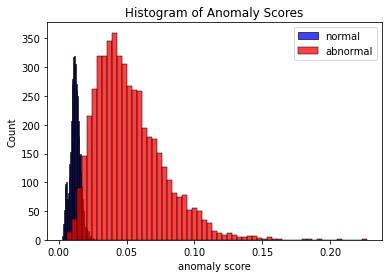

In [32]:
# get anomaly scores of valid set
df = get_anomaly_score(model, valid_loader)

# check statistics of anomlay scores according to class(normal or abnormal)
normal_df = df[df['target']==0]['anomaly score']
abnormal_df = df[df['target']==1]['anomaly score']

print(f'normal mean & std : ({round(normal_df.mean(),6)},{round(normal_df.std(),6)})')
print(f'normal max & min : ({round(normal_df.max(),6)},{round(normal_df.min(),6)}) \n')

print(f'abnormal mean & std : ({round(abnormal_df.mean(),6)},{round(abnormal_df.std(),6)})')
print(f'abnormal max & min : ({round(abnormal_df.max(),6)},{round(abnormal_df.min(),6)}) \n')

# histogram of anomlay scores according to class(normal or abnormal)
sns.histplot(df[df['target']==0]['anomaly score'],
             color='blue', label='normal')

sns.histplot(df[df['target']==1]['anomaly score'],
             color='red', label='abnormal')
plt.title('Histogram of Anomaly Scores')
plt.legend()

##### threshold grid search

In [53]:
def threshold_search(df:pd.DataFrame, min, max, step):
    search_space = np.arange(min, max+step, step)
    best_f1 = 0.
    best_acc = 0.
    best_threshold = 0.
    
    for threshold in search_space:
        crt_f1, crt_acc = anomaly_detection(df, threshold)
        
        if crt_f1 > best_f1:
            best_f1 = crt_f1
            best_threshold = threshold
            best_acc = crt_acc
    
    return round(best_f1*100,2), round(best_acc*100,2), round(best_threshold, 5)

best_f1, best_acc, best_threshold = threshold_search(df, 0.006, 0.028, 0.0005)

print(f'best f1-score : {best_f1} | best accuracy : {best_acc} | best threshold : {best_threshold}')

best f1-score : 96.58 | best accuracy : 96.61 | best threshold : 0.0195


테스트 집합 이상 탐지

Performace of our threshold -> f1-score : 96.54 | accuracy : 96.57


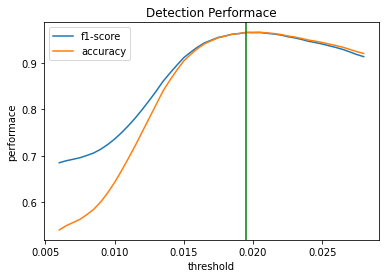

In [72]:
# get anomaly scores of test set
test_df = get_anomaly_score(model, test_loader)

search_space = np.arange(0.006, 0.028+0.0005, 0.0005)

f1_list = []
acc_list = []
our_threshold = best_threshold

for threshold in search_space:
    
    crt_f1, crt_acc = anomaly_detection(test_df, threshold)
    f1_list.append(crt_f1)
    acc_list.append(crt_acc)
    
    
sns.lineplot(search_space, f1_list, label='f1-score')
sns.lineplot(search_space, acc_list, label='accuracy')

plt.axvline(x=best_threshold, color='green')
plt.title('Detection Performace')
plt.xlabel('threshold')
plt.ylabel('performace')
plt.legend()

our_f1, our_acc = crt_f1, crt_acc = anomaly_detection(test_df, best_threshold)
print(f'Performace of our threshold -> f1-score : {round(our_f1*100,2)} | accuracy : {round(our_acc*100,2)}')